In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

# Measures

In [2]:
#-------Density-------------
def density_attr(df, attribute):
    density_values = np.array(df[attribute].value_counts(normalize=True))
    value_avg = density_values.mean()
    return 1 - np.sqrt((density_values - value_avg) ** 2).mean()
def density_df(df):
    return np.mean([density_attr(df, attr) for attr in df.columns])

In [3]:
def edit_density_attr(X,y, attribute, percentage):
    vc = X[attribute].value_counts()
    indexes = X[ X[attribute] == vc.index[1]].sample(frac=percentage, random_state=42).index
    X_new = X.drop(indexes)
    y_new = y.drop(indexes)
    return X_new, y_new

def edit_density_df(X, y, percentage):
    features = X.columns
    X_new = X.copy()
    y_new = y.copy()
    for f in features:
        if X[f].nunique() <= 6 and X[f].nunique() >= 2 :
            X_new, y_new = edit_density_attr(X_new, y_new, f, percentage)
    return X_new.reset_index(drop=True), y_new.reset_index(drop=True)

In [4]:
measures_steps = {
    'Density': [0, 0.1, 0.2, 0.4, 0.5]
}
n_steps = 5
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())

metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps)),
    'Precision': np.zeros((len(classifiers), n_steps)),
    'Recall': np.zeros((len(classifiers), n_steps)),
    'F1 Score': np.zeros((len(classifiers), n_steps))
}

# Dataset

In [5]:
heart_attack = pd.read_csv('dataset/heart_attack.csv')
heart_attack = heart_attack.sample(frac=1, random_state=42).reset_index(drop=True)
X = heart_attack.drop('output', axis=1)
y = heart_attack['output']
dataset_name = 'heart_attack'

In [8]:
stroke = pd.read_csv('dataset/stroke.csv').sample(frac=1,random_state=42).reset_index(drop=True)
X = stroke.drop(['stroke', 'id'], axis=1)
y = stroke['stroke']
X.fillna(method='ffill',inplace=True)

enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])

dataset_name = 'stroke'

In [11]:
marketing_campaign = pd.read_csv('dataset/marketing_campaign.csv',sep=';').sample(frac=1,random_state=42).reset_index(drop=True)
marketing_campaign = marketing_campaign.dropna()
marketing_campaign= marketing_campaign.reset_index(drop=True)
X = marketing_campaign.drop(['Response', 'ID', 'Dt_Customer'], axis=1)
y = marketing_campaign['Response']



enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])

dataset_name = 'marketing_campaign'

In [14]:
heart_failure = pd.read_csv('dataset/heart_failure.csv')
X = heart_failure.drop(['HeartDisease'], axis=1)
y = heart_failure['HeartDisease']


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'heart_failure'

In [17]:
airline_passenger = pd.read_csv('dataset/airline_passenger.csv')
airline_passenger.dropna(inplace=True)
airline_passenger = airline_passenger.reset_index(drop=True)

X = airline_passenger.drop(['satisfaction','Unnamed: 0','id'], axis=1)
y = airline_passenger['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'airline_passenger'

In [18]:
measure_value = []
for ii, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        X_new, y_new = edit_density_df(X, y, step)
        measure_value.append(density_df(X_new))

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            num_folds = 5
            kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_new)
            predictions = cross_val_predict(classifier, X_scaled, y_new, cv=kf)

            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = accuracy_score(y_new, predictions)
            metrics['Precision'][j, i] = precision_score(y_new, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_new, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_new, predictions, average='weighted')

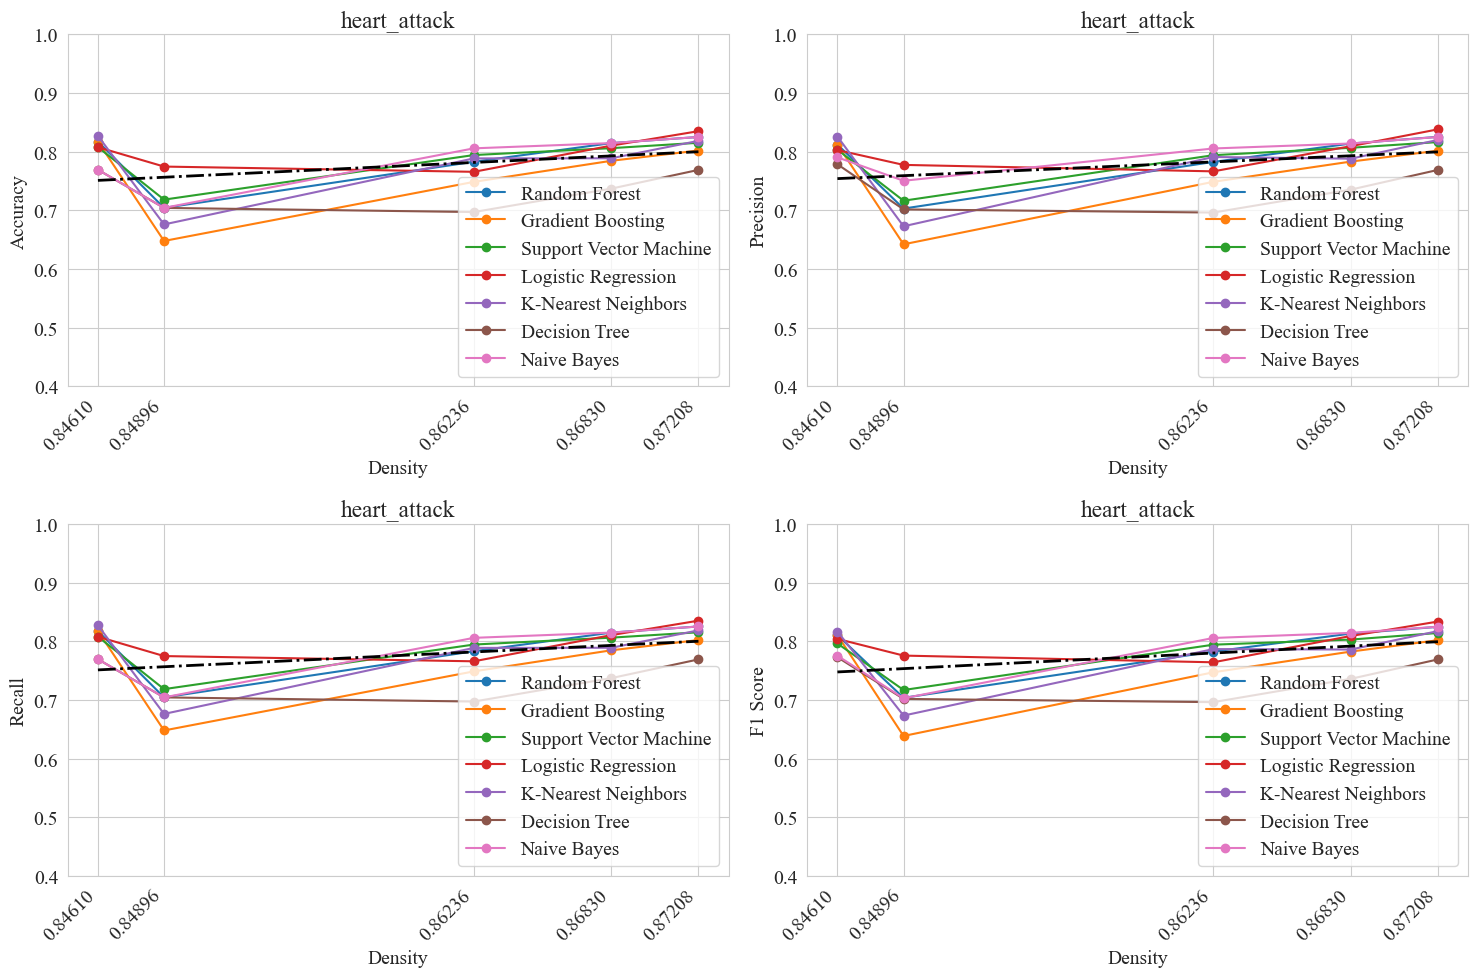

In [7]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/density_{dataset_name}.svg', format='svg')
plt.show()

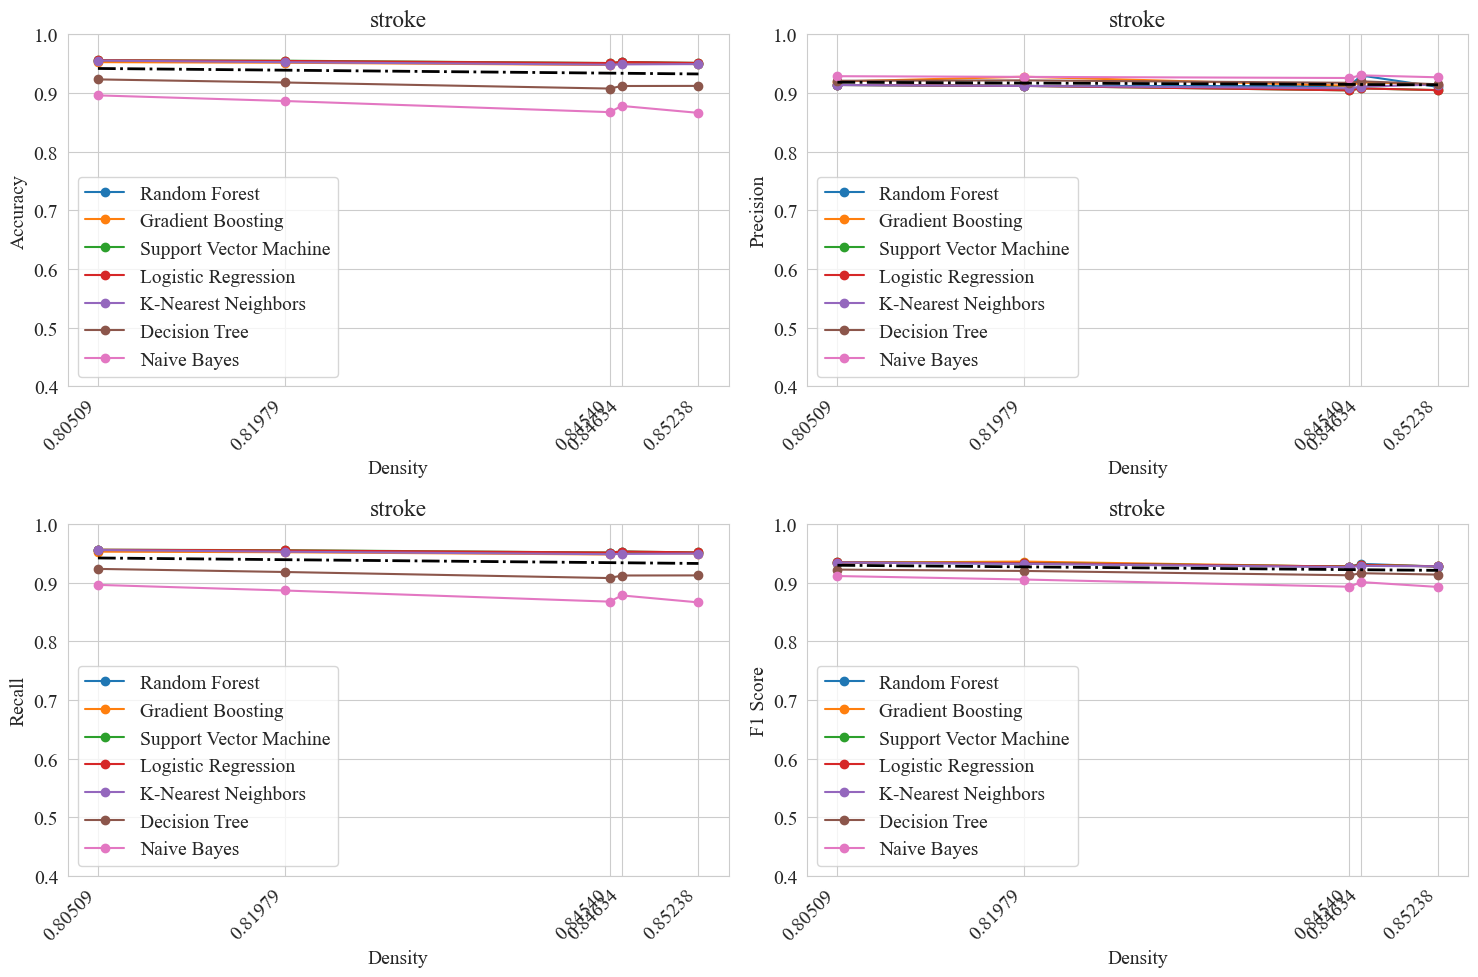

In [10]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/density_{dataset_name}.svg', format='svg')
plt.show()

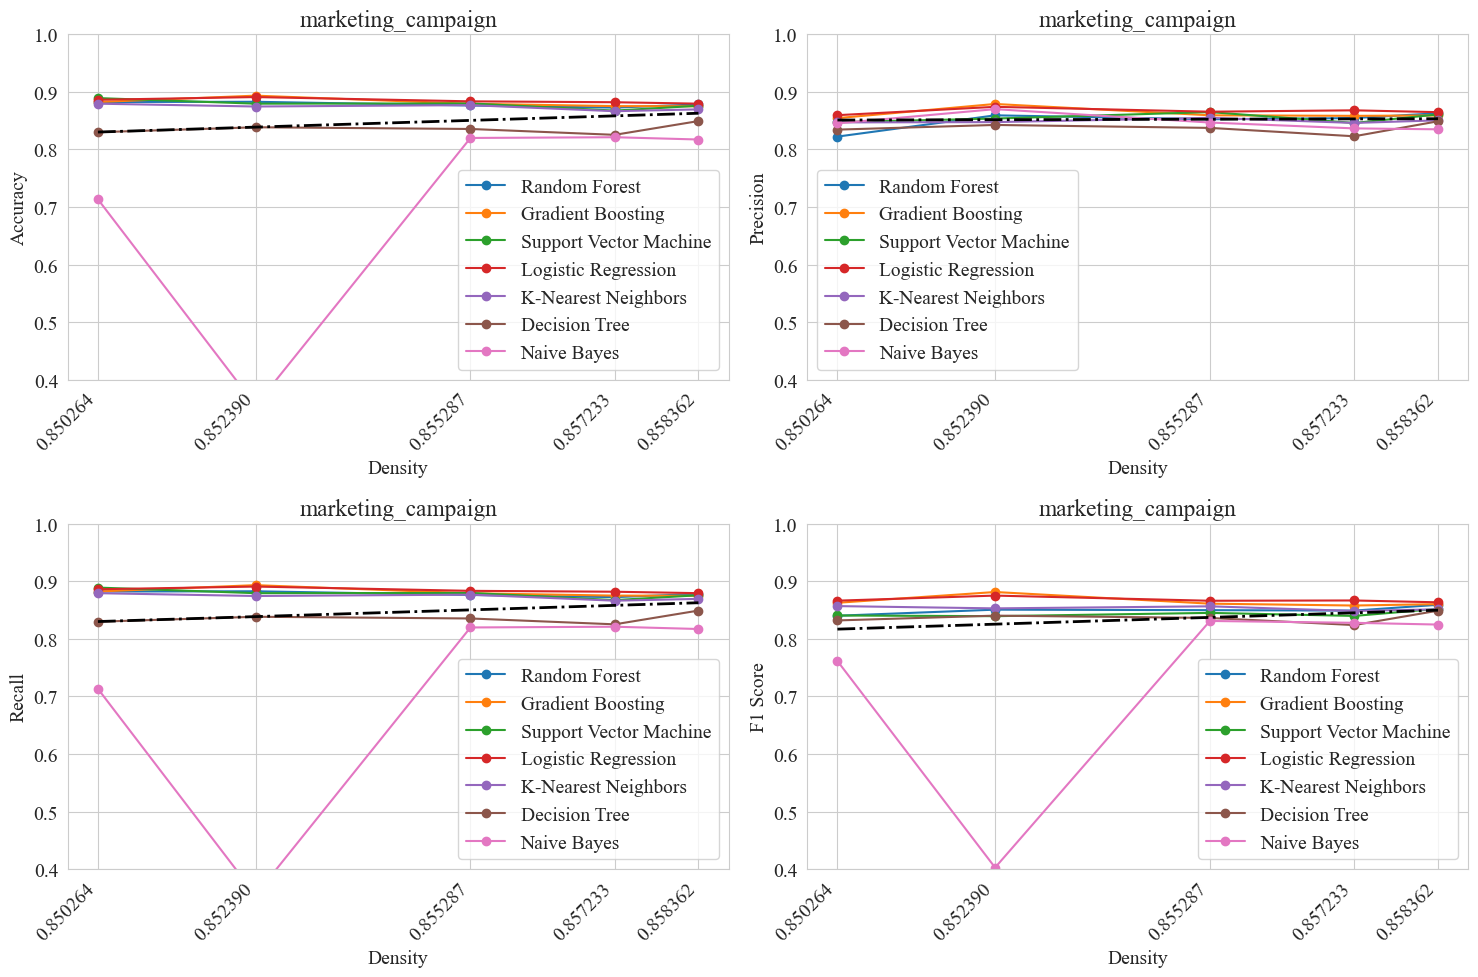

In [13]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/density_{dataset_name}.svg', format='svg')
plt.show()

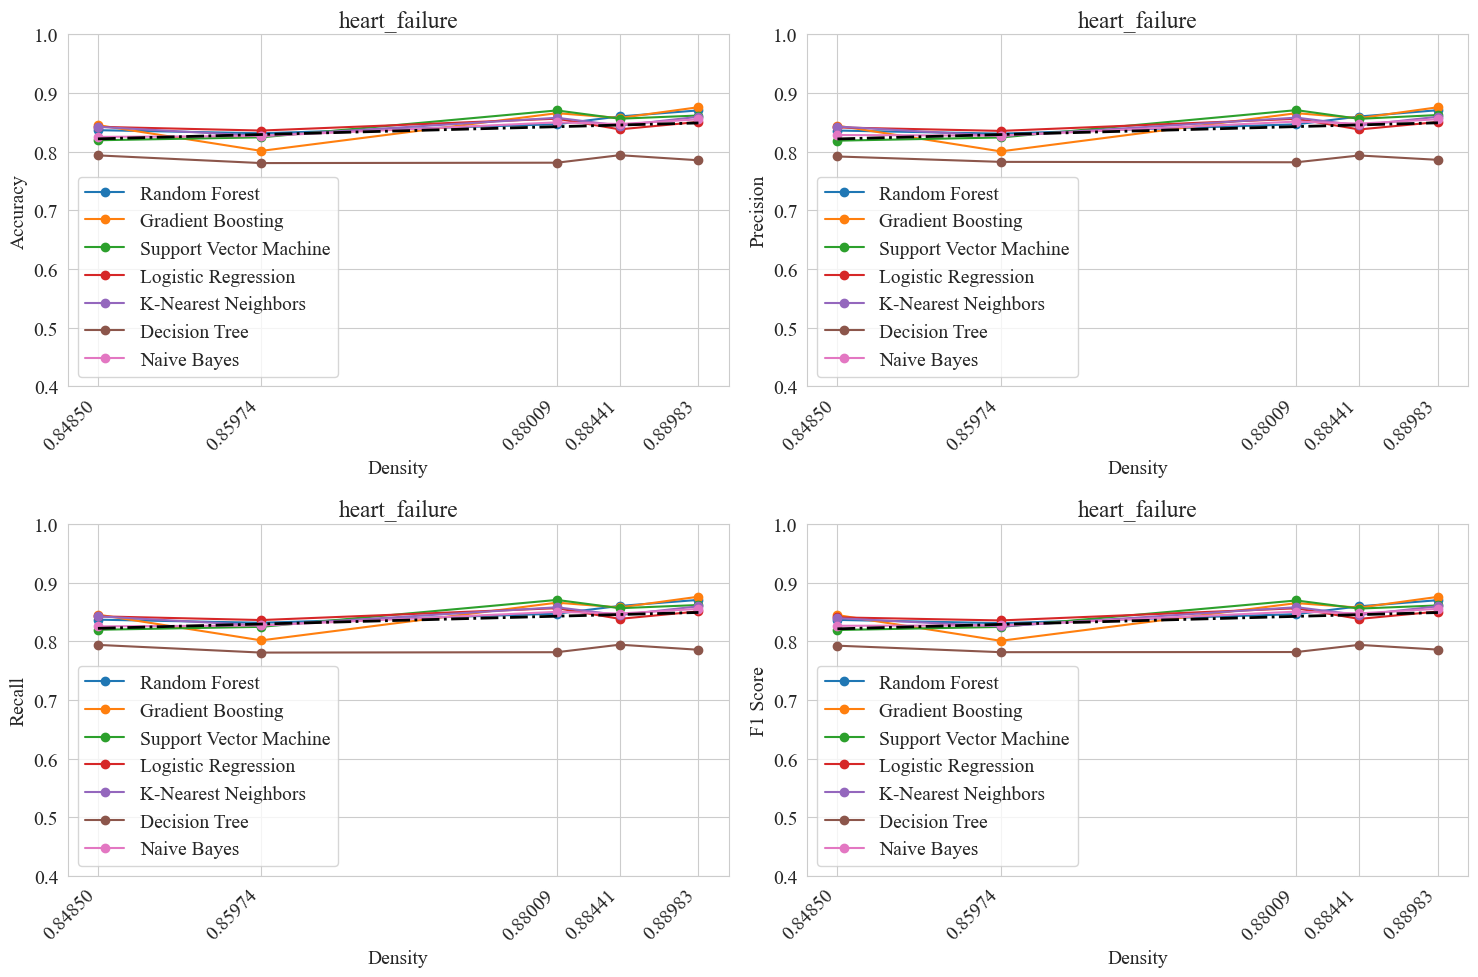

In [16]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/density_{dataset_name}.svg', format='svg')
plt.show()

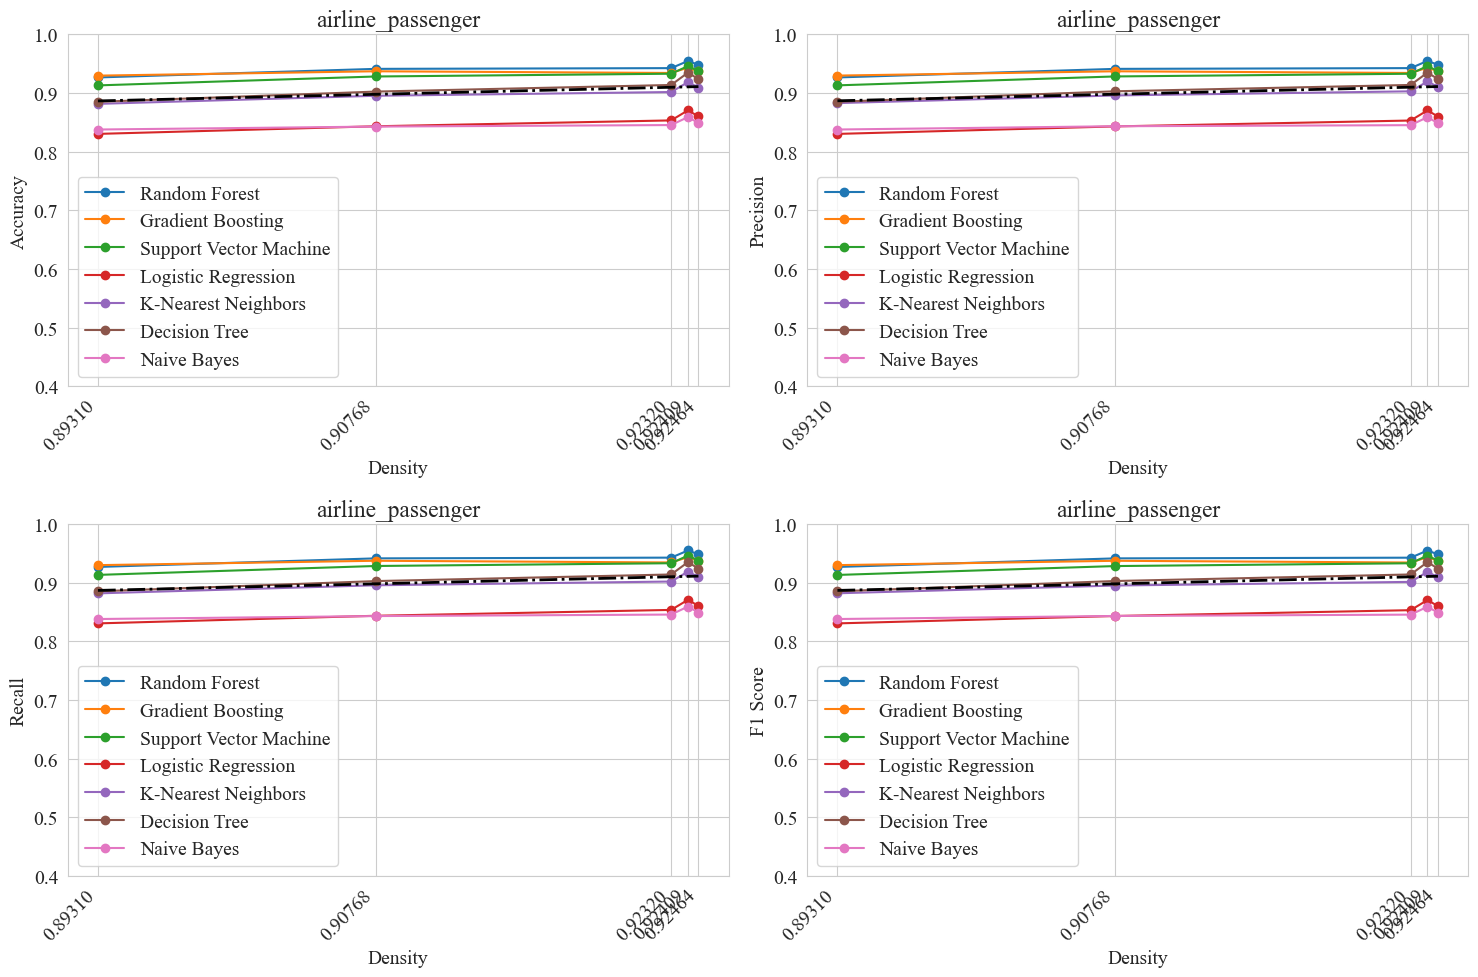

In [19]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/density_{dataset_name}.svg', format='svg')
plt.show()
